In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import math

import yfinance as yf
yf.pdr_override()

from datetime import datetime

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, LSTM, GRU, BatchNormalization, Dropout

from keras.callbacks import EarlyStopping

In [ ]:
stock = "CIPLA.NS"
startdate = datetime(2015,4,1)
enddate = datetime(2023,6,30)
data = pdr.get_data_yahoo(stock, start=startdate, end=enddate)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-01,714.000000,716.500000,703.849976,709.599976,686.310181,1693796
2015-04-06,714.000000,739.099976,711.549988,735.650024,711.505188,2457940
2015-04-07,740.000000,744.700012,722.400024,728.200012,704.299744,1652776
2015-04-08,732.000000,746.099976,724.599976,736.700012,712.520752,2259141
2015-04-09,741.700012,741.849976,715.299988,719.450012,695.836914,1409699


In [ ]:
data.shape

(2036, 6)

In [ ]:
# using the closed price to predict the future

df=data['Close']

In [ ]:
df.head(2)

Date
2015-04-01    709.599976
2015-04-06    735.650024
Name: Close, dtype: float64

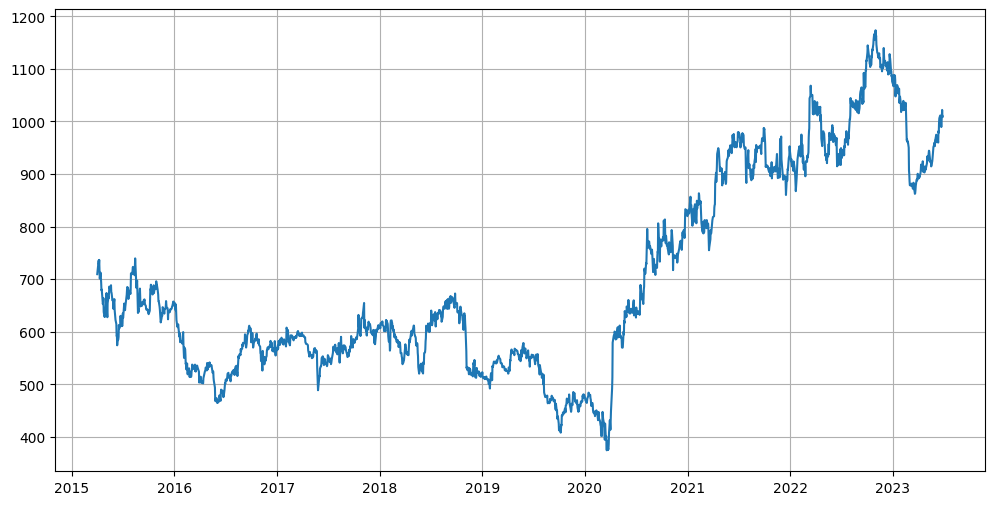

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df)
plt.grid()
plt.show()

In [ ]:
# scaling the feature
df=df.values
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(df.reshape(-1,1))

In [ ]:
df2[:5]

array([[0.41930632],
       [0.45192188],
       [0.44259421],
       [0.4532365 ],
       [0.43163891]])

In [ ]:
df2.shape

(2036, 1)

### Preprocessing the data

In [ ]:
training_size=int(len(df2)*0.70)  # 70% data
test_size=len(df2)-training_size

print("training size :",training_size,'test size :',test_size)

train_data, test_data= df2[ :training_size, :], df2[ training_size:len(df2), :1]

training size : 1425 test size : 611


In [ ]:
train_data[:6]

array([[0.41930632],
       [0.45192188],
       [0.44259421],
       [0.4532365 ],
       [0.43163891],
       [0.40872669]])

In [ ]:
test_data[:5]

array([[0.60366841],
       [0.58651559],
       [0.58470013],
       [0.58369852],
       [0.56216351]])

In [ ]:
# converting to matrix

def create_dataset(dataset, time_step=1):
  datax, datay =[], []

  for i in range(len(dataset)- time_step-1):
    a=dataset[i:(i+time_step),0]
    datax.append(a)
    datay.append(dataset[i+time_step, 0])

  return np.array(datax), np.array(datay)

In [ ]:
time_step=100  #We are doing for 100 days prediction

xtrain, ytrain= create_dataset(train_data, time_step)
xtest,ytest= create_dataset(test_data, time_step)

In [ ]:
print(xtrain.shape, ytrain.shape)

(1324, 100) (1324,)


In [ ]:
print(xtrain)

[[0.41930632 0.45192188 0.44259421 ... 0.3967697  0.40403156 0.32696877]
 [0.45192188 0.44259421 0.4532365  ... 0.40403156 0.32696877 0.33892576]
 [0.44259421 0.4532365  0.43163891 ... 0.32696877 0.33892576 0.32897207]
 ...
 [0.4827219  0.49718288 0.49699512 ... 0.55746838 0.56579436 0.57286839]
 [0.49718288 0.49699512 0.48848123 ... 0.56579436 0.57286839 0.56660821]
 [0.49699512 0.48848123 0.480343   ... 0.57286839 0.56660821 0.56354071]]


### Model Building ::

In [ ]:
xtrain=xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1)
xtest=xtest.reshape(xtest.shape[0],xtest.shape[1],1)

In [ ]:
model=Sequential()

model.add(LSTM(1000,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(512, return_sequences=True,dropout=0.3))
model.add(LSTM(128, return_sequences=True,dropout=0.3))
model.add(BatchNormalization())
model.add(LSTM(64))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 100, 1000)         4008000   
                                                                 
 lstm_62 (LSTM)              (None, 100, 512)          3098624   
                                                                 
 lstm_63 (LSTM)              (None, 100, 128)          328192    
                                                                 
 batch_normalization_26 (Bat  (None, 100, 128)         512       
 chNormalization)                                                
                                                                 
 lstm_64 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                     

In [ ]:
model1=Sequential()

model1.add(GRU(1000,return_sequences=True, input_shape=(100,1)))
model1.add(GRU(512, return_sequences=True,dropout=0.3))
model1.add(GRU(128, return_sequences=True,dropout=0.3))
model1.add(BatchNormalization())
model1.add(GRU(64))

model1.add(Dense(1))

model1.compile(loss='mean_squared_error', optimizer='adam')

model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 100, 1000)         3009000   
                                                                 
 gru_23 (GRU)                (None, 100, 512)          2325504   
                                                                 
 gru_24 (GRU)                (None, 100, 128)          246528    
                                                                 
 batch_normalization_27 (Bat  (None, 100, 128)         512       
 chNormalization)                                                
                                                                 
 gru_25 (GRU)                (None, 64)                37248     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                     

In [ ]:
callbacks= EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    min_delta=0.00001
)

In [ ]:
model.fit(xtrain,ytrain, validation_data=(xtest, ytest), epochs=100, batch_size=32, callbacks=callbacks, verbose=1)

Epoch 1/100
42/42 [==============================] - 14s 121ms/step - loss: 0.0565 - val_loss: 0.3270
Epoch 2/100
42/42 [==============================] - 4s 99ms/step - loss: 0.0016 - val_loss: 0.3426
Epoch 3/100
42/42 [==============================] - 3s 82ms/step - loss: 0.0014 - val_loss: 0.3491
Epoch 4/100
42/42 [==============================] - 4s 87ms/step - loss: 0.0013 - val_loss: 0.3222
Epoch 5/100
42/42 [==============================] - 4s 87ms/step - loss: 0.0012 - val_loss: 0.3818
Epoch 6/100
42/42 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 0.3080
Epoch 7/100
42/42 [==============================] - 4s 87ms/step - loss: 0.0011 - val_loss: 0.3028
Epoch 8/100
42/42 [==============================] - 3s 83ms/step - loss: 0.0012 - val_loss: 0.4301
Epoch 9/100
42/42 [==============================] - 4s 86ms/step - loss: 9.3753e-04 - val_loss: 0.3105
Epoch 10/100
42/42 [==============================] - 4s 87ms/step - loss: 0.0014 - val_loss: 

In [ ]:
model1.fit(xtrain,ytrain, validation_data=(xtest, ytest), epochs=100, batch_size=32, callbacks=callbacks, verbose=1)

Epoch 1/100
42/42 [==============================] - 13s 104ms/step - loss: 0.2860 - val_loss: 0.1918
Epoch 2/100
42/42 [==============================] - 3s 71ms/step - loss: 0.0054 - val_loss: 0.2452
Epoch 3/100
42/42 [==============================] - 3s 71ms/step - loss: 0.0026 - val_loss: 0.2278
Epoch 4/100
42/42 [==============================] - 3s 76ms/step - loss: 0.0015 - val_loss: 0.2345
Epoch 5/100
42/42 [==============================] - 3s 71ms/step - loss: 0.0013 - val_loss: 0.2457
Epoch 6/100
42/42 [==============================] - 3s 77ms/step - loss: 0.0011 - val_loss: 0.2258
Epoch 7/100
42/42 [==============================] - 3s 71ms/step - loss: 8.3279e-04 - val_loss: 0.2059
Epoch 8/100
42/42 [==============================] - 3s 71ms/step - loss: 7.4070e-04 - val_loss: 0.2030
Epoch 9/100
42/42 [==============================] - 3s 71ms/step - loss: 7.7197e-04 - val_loss: 0.1821
Epoch 10/100
42/42 [==============================] - 3s 78ms/step - loss: 8.0115e-04 

### Predicting and plotting

In [ ]:
#LSTM
train_predict=model.predict(xtrain)

test_predict=model.predict(xtest)

16/16 [==============================] - 0s 27ms/step


In [ ]:
# GRU
train_predict1=model1.predict(xtrain)

test_predict1=model1.predict(xtest)

16/16 [==============================] - 0s 24ms/step


In [ ]:
## Transform back to the original form....because for calculationg RMSE performance metrics

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

train_predict1=scaler.inverse_transform(train_predict1)
test_predict1=scaler.inverse_transform(test_predict1)

In [ ]:
# lstm

print("Train RSME for LSTM : ",math.sqrt(mean_squared_error(ytrain,train_predict)))
print("Test RSME for LSTM :",math.sqrt(mean_squared_error(ytest,test_predict)))

# GRU
print("Train RSME for GRU: ",math.sqrt(mean_squared_error(ytrain,train_predict1)))
print("Test RSME for GRU :",math.sqrt(mean_squared_error(ytest,test_predict1)))

Train RSME for LSTM :  538.0972659559159
Test RSME for LSTM : 876.3762822446812
Train RSME for GRU:  533.5661794715618
Test RSME for GRU : 917.1140760154019


- Increasing the neurons and layers might decrease the loss occured.
- GRU has the less loss compared with LSTM

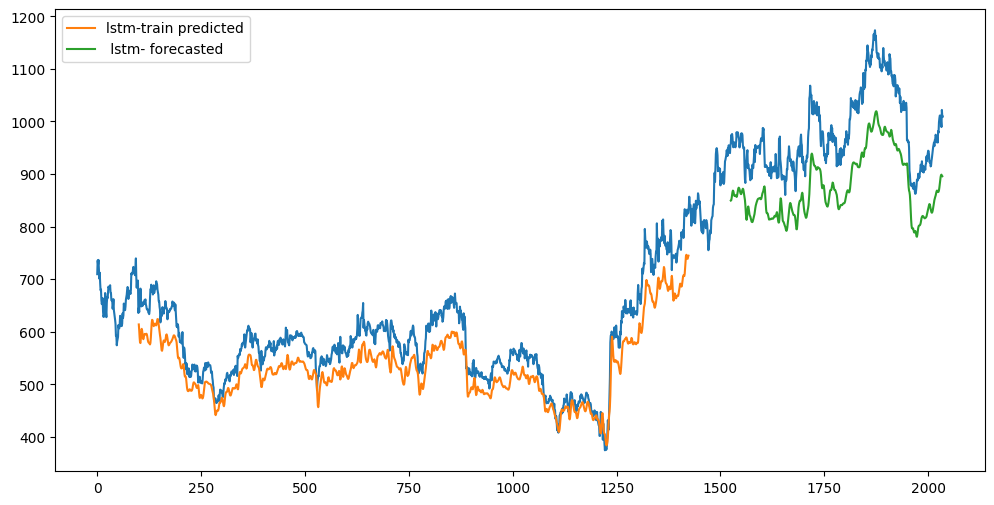

In [ ]:
look_back=100    # time step we picked 100
trainpredictplot=np.empty_like(df2)
trainpredictplot[:,:] = np.nan                  # based on the size of dataframe i am keeping nan every where
trainpredictplot[look_back: len(train_predict)+look_back, : ]= train_predict   # filling that nan with train predict data

# doing the same steps for the test predict

# shifting test predictions to plotting
testpredictplot=np.empty_like(df2)
testpredictplot[:,:] = np.nan
testpredictplot[len(train_predict)+(look_back*2)+1:len(df2)-1, : ]= test_predict

# plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(df2))  # our complete data set
plt.plot(trainpredictplot, label='lstm-train predicted')   # this we have already perform scaler inverse transform.. for test and train
plt.plot(testpredictplot, label=' lstm- forecasted')
plt.legend()
plt.show()

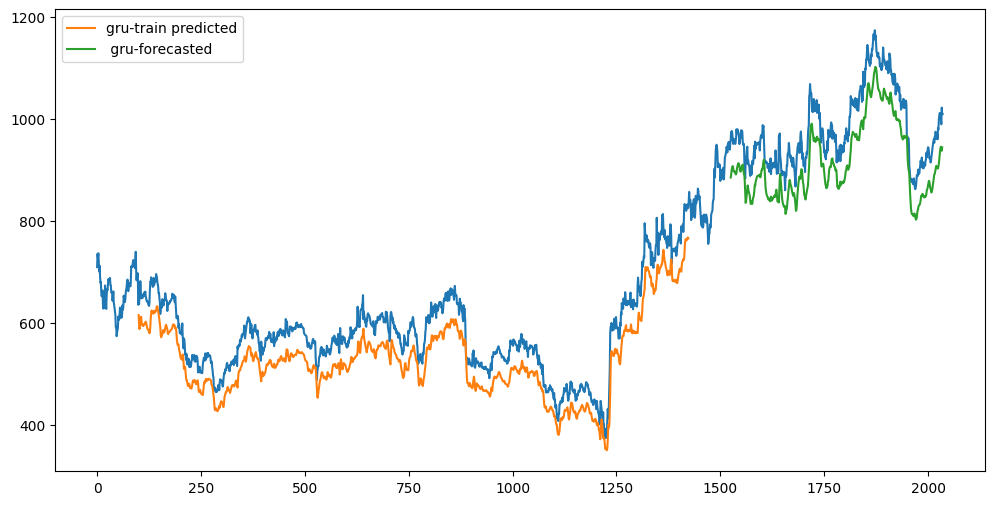

In [ ]:
look_back=100     # time step we picked 100
trainpredictplot=np.empty_like(df2)
trainpredictplot[:,:] = np.nan                  # based on the size of dataframe i am keeping nan every where
trainpredictplot[look_back: len(train_predict1)+look_back, : ]= train_predict1   # filling that nan with train predict data

# doing the same steps for the test predict

# shifting test predictions to plotting
testpredictplot=np.empty_like(df2)
testpredictplot[:,:] = np.nan
testpredictplot[len(train_predict1)+(look_back*2)+1:len(df2)-1, : ]= test_predict1

# plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(df2))  # our complete data set
plt.plot(trainpredictplot, label='gru-train predicted')   # this we have already perform scaler inverse transform.. for test and train
plt.plot(testpredictplot, label=' gru-forecasted')
plt.legend()
plt.show()